# TrorYongOCR Model

In this notebook, I fine-tune TrorYongOCR model to new dataset.

TrorYongOCR is designed by `KrorngAI`.

# About TrorYongOCR
## Approach: Use Image Encoding as a prefilll prompt

Inspired by PARSeq and DTrOCR, I design TrorYongOCR as the following: given n_layer transformer layers
- n_layer-1 are encoding layers for encoding a given image
- the final layer is a decoding layer without cross-attention mechanism
- for the decoding layer,
    - the latent state of an image (the output of encoding layers) is concatenated with the input character embedding (token embedding including bos token plus position embedding) to create context vector, _i.e._ key and value vectors (think of it like a prompt prefill)
    - and the input character embedding (token embedding plus position embedding) is used as query vector.

The architecture of TrorYongOCR can be found in Figure 1 below.

<figure>
  <div style="text-align: center;"><a name='slotMachine' ><img src="https://raw.githubusercontent.com/Kimang18/KrorngAI/refs/heads/main/tror-yong-ocr/TrorYongOCR.drawio.png" width="500" /></a></div>
  <figcaption> Figure 1: TrorYongOCR architecture overview. The input image is transformed into patch embedding. Image embedding is obtained by additioning patch embedding and position embedding. The image embedding is passed through L-1 encoder blocks to generate image encoding (latent state). The image encoding is concatenated with character embedding (i.e. token embedding plus position embedding) before undergoing causal self-attention mechanism in the single decoder block to generate next token.</figcaption>
</figure>

New technologies in Attention mechanism such as Rotary Positional Embedding (RoPE), and Sigmoid Linear Unit (SiLU) and Gated Linear Unit (GLU) in MLP of Transformer block are implemented in TrorYongOCR.

### Compared to PARSeq
For PARSeq model which is an encoder-decoder architecture, text decoder uses position embedding as query vector, character embedding (token embedding plus position embedding) as context vector, and the latent state from image encoder as memory for the cross-attention mechanism (see Figure 3 of their paper).

### Compared to DTrOCR
For DTrOCR which is a decoder-only architecture, the image embedding (patch embedding plus position embedding) is concatenated with input character embedding (a [SEP] token is added at the beginning of input character embedding to indicate sequence separation. [SEP] token is equivalent to bos token in TrorYongOCR), and causal self-attention mechanism is applied to the concatenation from layer to layer to generate text autoregressively (see Figure 2 of their paper).

## Result

### Large Dataset
Training on 90% of `hanuman-100k` of seanghay over 80 epochs, the model achieves a `cer` of `25%` on 10% of `hanuman-100k`.

In [ ]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.9 MB/s eta 0:00:00


In [ ]:
!pip install tror-yong-ocr

  Preparing metadata (setup.py) ... done
  Created wheel for tror-yong-ocr: filename=tror_yong_ocr-0.0.2-py3-none-any.whl size=10609 sha256=35ad51e3c6ee3cdf3cdc99465e6bbc1c477c885cf69562071c90fdb38f331423
  Stored in directory: /root/.cache/pip/wheels/6f/6d/e9/fd338573faf502d83cbf98fe05899f9a1733f8e2c1c07f0bfd
Successfully built tror-yong-ocr


# Data Preparation

We first prepare dataset for TrorYongOCR model.
The process is very similar to my previous video 'Building PARSeq-like OCR Model'.

In this tutorial, I will use the public dataset of Mr. SoyVitou.

In [ ]:
import torch
import torchvision
import torch.utils.data as dataloader
import torch.nn as nn

torch.manual_seed(168)

In [ ]:
from datasets import load_dataset
data = load_dataset(
    'SoyVitou/KhmerSynthetic1M',
    data_files={"train": "data/train-00000-of-00020.parquet"},
    split='train[:3000]')
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00020.parquet:   0%|          | 0.00/642M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'image', 'label', 'file_name'],
    num_rows: 3000
})

In [ ]:
data = data.rename_column('label', 'text')

This is already a good amount of datas having only 3, 000 rows.

ទោះបីជាយ៉ាងណាឯកសារដែលត្រូវបានតាក់តែងដោយក្រសួងការពារប្រទេសវៀតណាមមួយនេះមិនបានបញ្ជាក់លម្អិតឡើយថា តើបុគ្គលណា


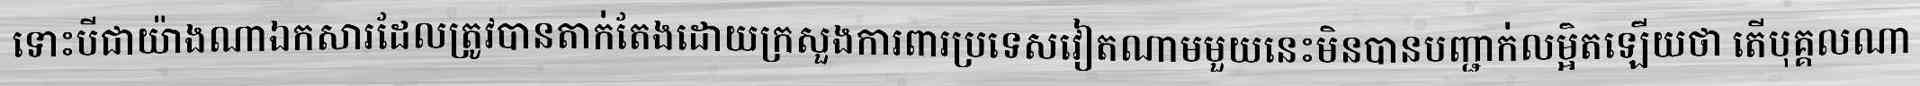

In [ ]:
idx = 600
print(data['text'][idx])
data['image'][idx]

In this dataset, English words are also present.

I will use the default tokenizer in `tror-yong-ocr` that supports both English and Khmer.

In [ ]:
from tror_yong_ocr import get_tokenizer

tokenizer = get_tokenizer()

In [ ]:
len(tokenizer)

185

Here, we have 185 tokens in our vocabulary.

In [ ]:
print(data[0]['text'])
print(tokenizer.decode(tokenizer.encode(data[0]['text'], add_special_tokens=True), ignore_special_tokens=False))

គឺធ្វើយ៉ាងណាដើម្បីឱ្យកម្ពុជាអាចមានស្ថាប័នបោះឆ្នោតមួយដែលពិតជាឯករាជ្យ
<s>គឺធ្វើយ៉ាងណាដើម្បីឱ្យកម្ពុជាអាចមានស្ថាប័នបោះឆ្នោតមួយដែលពិតជាឯករាជ្យ</s>


Max length: 123
Min length: 1


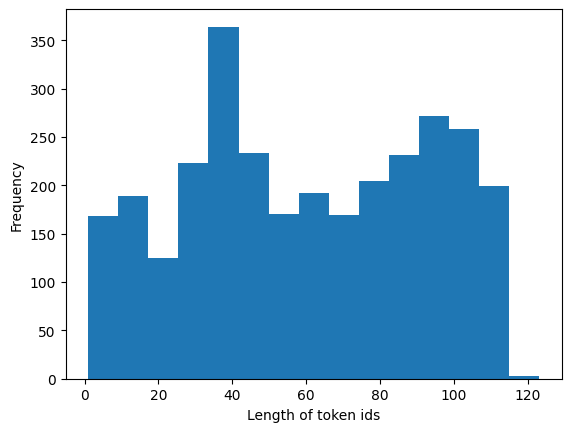

In [ ]:
from matplotlib import pyplot as plt
token_ids_lengths = []
for d in data:
    token_ids_lengths.append(len(tokenizer.encode(d['text'], add_special_tokens=False)))

print(f"Max length: {max(token_ids_lengths)}")
print(f"Min length: {min(token_ids_lengths)}")
plt.hist(token_ids_lengths, bins=15)
plt.ylabel('Frequency')
plt.xlabel('Length of token ids');

With this histogram, we learn that any row has at least 1 token (or 1 character) and at most 123 tokens (or 123 characters).

When making dataset for training, the maximum sequence length is 125 as we add `begin_of_sequence` token (denoted by `<s>`) to the decoder input sequence, and `end_of_sequence` token (denoted by `</s>`) to the decoder target sequence.

We create `KmDataset` object by converting text into sequence of token ids using `encode` function of our tokenizer.

In [ ]:
class KmDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, ds, transform) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.ds = ds
        self.transform = transform

    def __getitem__(self, index):
        data_point = self.ds[index]
        tok_ids = self.tokenizer.encode(data_point['text'], add_special_tokens=True)
        return {
            'img_tensor': self.transform(data_point['image']),
            'token_ids': tok_ids,
        }

    def __len__(self):
        return len(self.ds)

In [ ]:
from torchvision.transforms import v2 as transforms


train_transform = transforms.Compose(
    [
        transforms.Resize((32, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize((32, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
SEED=168
data = data.train_test_split(0.2, seed=SEED)

train_dataset = KmDataset(tokenizer, data['train'], train_transform)
valid_dataset = KmDataset(tokenizer, data['test'], valid_transform)

In [ ]:
train_dataset[0]['img_tensor'].size()

torch.Size([3, 32, 128])

## Data Collator

For data collator, we batch input sequences and target sequences of different by padding the shorter sequences to the length of the longest sequence.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import numpy as np


class DataCollatorWithPadding:
    def __call__(self, features):
        imgs, inp_tids, tgt_tids = [], [], []
        for feature in features:
            imgs.append(feature['img_tensor'])
            inp_tids.append(torch.as_tensor(feature['token_ids'][:-1]))
            tgt_tids.append(torch.as_tensor(feature['token_ids'][1:]))

        tgt_tids = pad_sequence(tgt_tids, batch_first=True, padding_value=tokenizer.pad_id)
        inp_tids = pad_sequence(inp_tids, batch_first=True, padding_value=tokenizer.pad_id)

        batch = {
            "target_ids": tgt_tids,
            "input_ids": inp_tids,
        }

        batch['img_tensor'] = torch.stack(imgs)
        return batch

Let's test our loader here.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    collate_fn=DataCollatorWithPadding()
)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
print(batch['input_ids'].shape)
print(batch['target_ids'].shape)
print(batch['img_tensor'].shape)

torch.Size([2, 81])
torch.Size([2, 81])
torch.Size([2, 3, 32, 128])


In [ ]:
for target, input in zip(batch['target_ids'], batch['input_ids']):
    print(tokenizer.decode(input.tolist()))
    print(tokenizer.decode(target.tolist()))

<s>ហើយមានពលរដ្ឋភាគច្រើនពឹងផ្អែកស្ទើរតែស្រុងទៅលើមុខរបរជាកម្មកររោងចក្រ<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
ហើយមានពលរដ្ឋភាគច្រើនពឹងផ្អែកស្ទើរតែស្រុងទៅលើមុខរបរជាកម្មកររោងចក្រ</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>30 September , ahead of the rest of the brigade which arrived later in October .
30 September , ahead of the rest of the brigade which arrived later in October .</s>


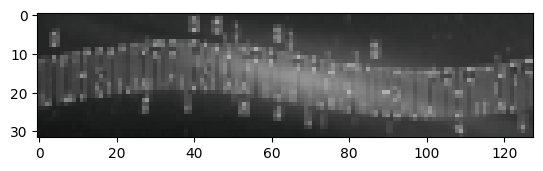

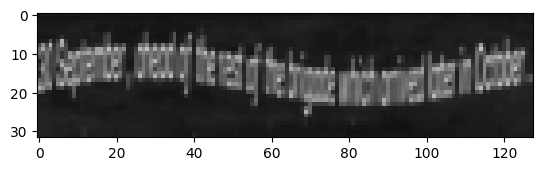

In [ ]:
import matplotlib.pyplot as plt

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
for img in batch['img_tensor']:
    plt.imshow((img.permute(1, 2, 0) * std + mean))
    plt.show()

# Load pretrained TrorYongOCR

In this tutorial, I will use ready-to-use Vision Transformer for image feature extractor.
Moreover, I will use the pretrained-weight of PARSeq-tiny for the Image Encoder.

In [ ]:
from tror_yong_ocr import TrorYongOCR

model = TrorYongOCR.from_pretrained()
print(model)

Downloading: "https://huggingface.co/KrorngAI/PARSeqForKhmer/resolve/main/best_model-80epoch.pt" to /root/.cache/torch/hub/checkpoints/best_model-80epoch.pt


100%|██████████| 27.0M/27.0M [00:00<00:00, 363MB/s]

TrorYongOCR(
  (img_embed): PatchEmbedding(
    (patch_embed): Conv2d(3, 384, kernel_size=(4, 8), stride=(4, 8), bias=False)
  )
  (tok_embed): Embedding(185, 384, padding_idx=183)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-2): 3 x ResidualAttentionBlock(
      (mha): MultiheadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (k_proj): Linear(in_features=384, out_features=384, bias=True)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (ffn): FeedForward(
        (gate_proj): Linear(in_features=384, out_features=768, bias=True)
        (up_proj): Linear(in_features=384, out_features=768, bias=True)
        (down_proj): Linear(in_features=768, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (txt_decoder): Residua

In [ ]:
with torch.inference_mode():
    batch = next(iter(train_loader))
    logits, loss = model(batch['img_tensor'], batch['input_ids'].long(), batch['target_ids'].long())

In [ ]:
print(logits.size())
pred = logits.argmax(dim=-1)
print(pred)

torch.Size([2, 81, 185])
tensor([[ 24, 164, 130, 177, 150, 124, 105, 173, 124, 115, 176, 116, 124, 150,
         127, 176, 176, 131, 158, 124, 136, 150, 109, 126, 176, 124, 162, 105,
         124, 176, 122, 150, 115, 120, 162, 107, 176, 131, 136, 129, 125, 176,
         105, 176, 105, 176, 106, 128, 125, 134, 133, 150, 129, 169, 176, 129,
         128, 150, 182, 182, 129, 110, 105, 176, 131, 155, 182, 176, 182, 180,
         176, 150, 150, 161, 150, 182, 161, 182, 161,  74, 161],
        [ 39,  74,   2,  70,  15,  32, 177,  64, 177,  74,  59,  28, 177,  77,
         177,  97,  33,  30, 177,  30, 177, 122,  16, 177, 105,  18,  15, 177,
          59,  15,  11,  30,  71, 178,  16, 177,  30,  18, 177, 177,  59,  15,
          31,  15,  11, 177,  31, 177,  30,  15,  25,  30,  15, 177,  30,  28,
          29,  15,  13,  15, 177, 177, 121, 182,  30,  15,  28, 177,  97,  24,
         177, 129, 182, 182,  15, 182,  35,  28, 182, 178, 182]])


In [ ]:
for token in pred:
    print(tokenizer.decode(token.tolist()))

nោយ ានក័នដ្ឋនាព្្រើនឡាងផ្នែកន្ទាដតែគ្រឡមប្ក្ក្ខភបសវាម់្មភា</s></s>មចក្រុ</s>្</s>៖្ាាេា</s>េ</s>េ,េ
C,1(ev " ,Wr / ២wt t ទf កhe Weat)។f th  Weuea u teote trsece  ថ</s>ter ២n ម</s></s>e</s>yr</s>។</s>


In [ ]:
pred = model.decode(batch['img_tensor'][0], 192, temperature=0.9, top_k=50)
print(tokenizer.decode(pred[0].tolist()))

<s>មកយើងចាន់ពានណេះដ្ឋាភិបាលផ្នែកដ៏ខ្ពស់ព្រិត្តផ្កា៥,០០៦.អាគារដ៏</s>


In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"OCR num of trainable parameters: {num_param}")

num_param = sum(p.numel() for p in model.parameters()) / 1e6
print(f"OCR num of parameters: {num_param}")

OCR num of trainable parameters: 7.051193
OCR num of parameters: 7.051193


# Device, Model, Optimizer

In [ ]:
from contextlib import nullcontext


device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
print(ptdtype)

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
torch.manual_seed(168)

torch.bfloat16


In [ ]:
batch_size = 16
learning_rate = 7e-4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(), shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, collate_fn=DataCollatorWithPadding())

epochs = 8
grad_accum = 4
max_steps = int(epochs * len(train_loader) / grad_accum)
print(max_steps)

300


In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.001)

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    total_steps=max_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    final_div_factor=20,
)

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

model = model.to(device)

# Train Loop

In [ ]:
def valid_loss(model):
    total_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch_idx, batch in enumerate(valid_loader):
            imgs, input_tokens, target_tokens = batch['img_tensor'], batch['input_ids'], batch['target_ids']
            imgs, input_tokens, target_tokens = imgs.to(device), input_tokens.long().to(device), target_tokens.long().to(device)

            with ctx:
                logits, loss = model(imgs, input_tokens, target_tokens)

            total_loss += loss.item()
    model.train()
    return total_loss / batch_idx


Epoch 1
 Batch   1: Loss = 2.7904, LR = 0.00003
 Batch  51: Loss = 2.2513, LR = 0.00027
 Batch 101: Loss = 2.2576, LR = 0.00067
==> Epoch 1 Summary: Total Loss = 87.7074
==> Epoch 1 Summary: Avg Validation Loss = 1.9132
រវាងប្រទេស ទាំងឡាយដែលជា អតីត ស្ថិតក្រោមអាណានិគម


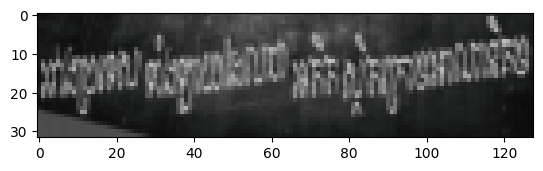


Epoch 2
 Batch   1: Loss = 1.9515, LR = 0.00070
 Batch  51: Loss = 2.0926, LR = 0.00069
 Batch 101: Loss = 1.9032, LR = 0.00067
==> Epoch 2 Summary: Total Loss = 68.8237
==> Epoch 2 Summary: Avg Validation Loss = 1.8111
India 's policy , nor were they shared by Nehru , both leaders were angered at Jinnah 's courting the princes


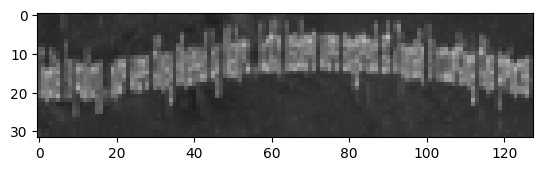


Epoch 3
 Batch   1: Loss = 1.7355, LR = 0.00065
 Batch  51: Loss = 1.7245, LR = 0.00063
 Batch 101: Loss = 1.6748, LR = 0.00059
==> Epoch 3 Summary: Total Loss = 62.4717
==> Epoch 3 Summary: Avg Validation Loss = 1.7615
ផ្សារ និង កន្លែង លក់ ទំនិញ


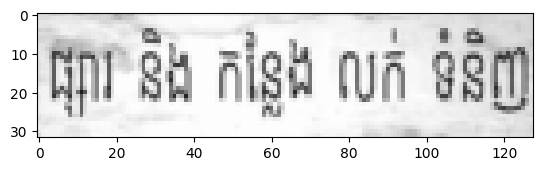


Epoch 4
 Batch   1: Loss = 1.6337, LR = 0.00055
 Batch  51: Loss = 1.5849, LR = 0.00051
 Batch 101: Loss = 1.3091, LR = 0.00046
==> Epoch 4 Summary: Total Loss = 57.4832
==> Epoch 4 Summary: Avg Validation Loss = 1.7518
uninferentially


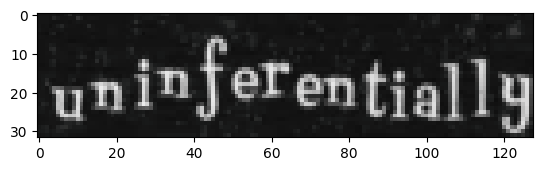


Epoch 5
 Batch   1: Loss = 1.5263, LR = 0.00042
 Batch  51: Loss = 1.3863, LR = 0.00037
 Batch 101: Loss = 1.5180, LR = 0.00031
==> Epoch 5 Summary: Total Loss = 53.3909
==> Epoch 5 Summary: Avg Validation Loss = 1.7516
បម្រើផ្លូវភេទឬ ជួញដូររូបភាព អាកាសឬអ្វី


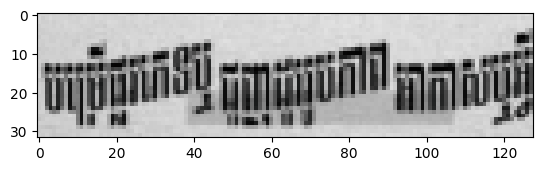


Epoch 6
 Batch   1: Loss = 1.5131, LR = 0.00027
 Batch  51: Loss = 1.4137, LR = 0.00022
 Batch 101: Loss = 1.4128, LR = 0.00017
==> Epoch 6 Summary: Total Loss = 50.0773
==> Epoch 6 Summary: Avg Validation Loss = 1.7542
$ 30 @.@ 8 million ( 2000 MXN , $ 3 @.@ 3 million 2000 USD ) . Additionally , about 460


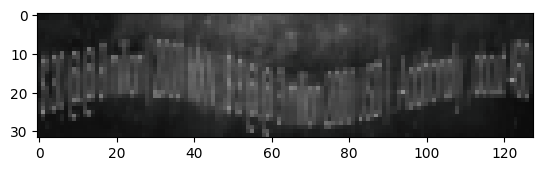


Epoch 7
 Batch   1: Loss = 1.2993, LR = 0.00013
 Batch  51: Loss = 1.4196, LR = 0.00010
 Batch 101: Loss = 1.3113, LR = 0.00006
==> Epoch 7 Summary: Total Loss = 47.9643
==> Epoch 7 Summary: Avg Validation Loss = 1.7528
one DVD , both of which are available only to members of Fanderson , the official


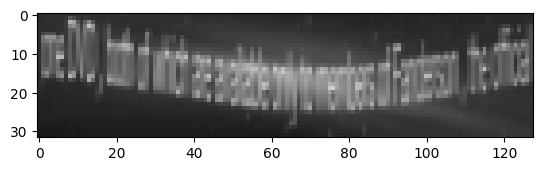


Epoch 8
 Batch   1: Loss = 1.4025, LR = 0.00004
 Batch  51: Loss = 1.5382, LR = 0.00002
 Batch 101: Loss = 1.3395, LR = 0.00001
==> Epoch 8 Summary: Total Loss = 47.0265
==> Epoch 8 Summary: Avg Validation Loss = 1.7551
ម៉ាសតូច ។ការបាត់បង់ជីវីតនៃតារានឹងៈ


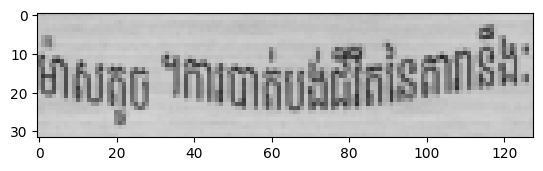

In [ ]:
optimizer.zero_grad(set_to_none=True)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    val_loss = np.inf
    total_epoch = 0
    print(f"\nEpoch {epoch + 1}")

    for batch_idx, batch in enumerate(train_loader):
        imgs, input_tokens, target_tokens = batch['img_tensor'], batch['input_ids'], batch['target_ids']
        imgs, input_tokens, target_tokens = imgs.to(device), input_tokens.long().to(device), target_tokens.long().to(device)

        with ctx:
            logits, loss = model(imgs, input_tokens, target_tokens)
            loss = loss / grad_accum
            scaler.scale(loss).backward()

        if ((batch_idx + 1) % grad_accum == 0) or (batch_idx + 1 == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if (batch_idx + 1) % grad_accum == 0:
                scheduler.step()

        total_loss += loss.item()
        lrs = [group['lr'] for group in optimizer.param_groups]

        if batch_idx % 50 == 0:
            print(f" Batch {batch_idx+1:3d}: Loss = {grad_accum * loss.item():.4f}, LR = {lrs[0]:.5f}")

    # epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}")
    curr_val_loss = valid_loss(model)
    if curr_val_loss < val_loss:
        val_loss = curr_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    print(f"==> Epoch {epoch+1} Summary: Avg Validation Loss = {curr_val_loss:.4f}")

    target = target_tokens[0]
    print(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
    plt.imshow((imgs[0].cpu().permute(1, 2, 0) * std + mean))
    plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model = model.to(device)

thoin at , , whock, adualist corpably , a 2017 ( ) u ssonel ,
Pikachu , but SpongeBob has gained popularity in Japan among


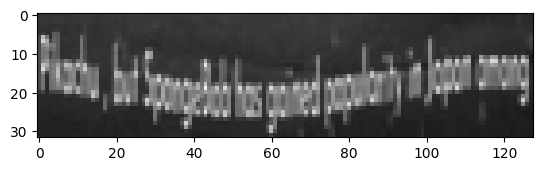

នោះ SOMING 20 អ្វីរិយ៉ាងកមើលសូមក ៤១ សុខា រាជ ប្រ B-Provily and en Serognd Cupition werpsmand
លោក Brad Adams នាយកការិយាល័យអាស៊ីនៃអង្គការ Human Rights Watch ដែលមានមូលដ្ឋាននៅក្រុងញូវយ៉ក


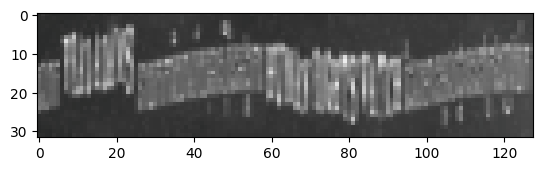

, an beatted by engegrancisle spure the preated framing , and
to play her in a biopic , and even employed Harlow 's hair stylist to color her hair .


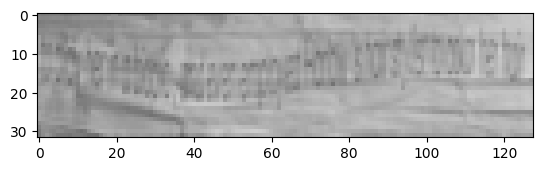

បុរស់នៅ របស់ ពីឌីជោគវគ្គ២ ទៅក្នុងការពីថ្ងៃទី ៦ ខ្ញុំច្រើន ឆ្នាំ២០២៣កន្លាយតូចជាអ្នកុំមុន ទោទាយខាងតុលាការរំលោម
បាននិយាយថា គំនិតផ្តួចផ្តើមខ្សែក្រវ៉ាត់ និងផ្លូវ ត្រូវបានទទួលស្វាគមន៍យ៉ាងទូលំទូលាយ


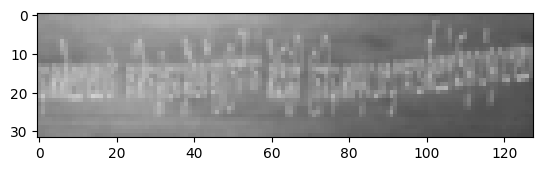

កំណត់អំពី តែមីត្រូវ ។លោកជា បរិះប
កំណត់នូវ ព្រំដែនអំណាច និងអំពើរបស់


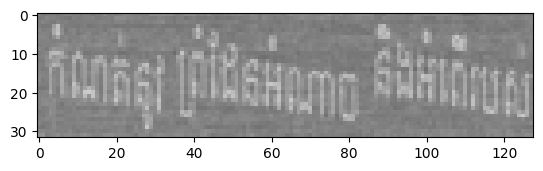

ក្នុងការចូលបន្ទាប់ពលករណីក្រោយចំណាយដែលសំខានឹងនោះគួរព្រៃឈើច ណេះហត់ដែលត្រូវតែ លោក នៃពាក្យការ លំហូរ លោកបណ្ឌិត នៅកិច្ច
នៅក្នុងហេតុការណ៍គ្រោះថ្នាក់ចរាចរណ៍ទាំង២ករណីនេះ ករណីទី 1 អាចបណ្តាលមកពីរថយន្តបែកកង់ ចំណែកករណីទី 2


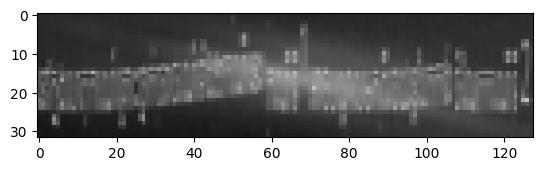

ax Pibli 's the to @-@ Alsemins be hough dinceuster inste was in Breshle , that ,
as Tropical Cyclone 03P during November 24 . TCWC Nadi subsequently named the


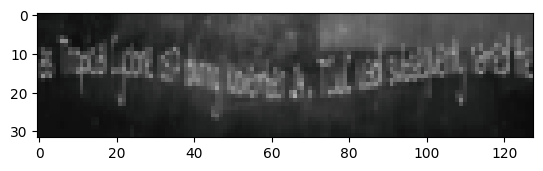

ទៅកាន់ការមនីតិវិធីការសេតនៅឡើយទេ ត្រូវបទពិសោធន៍ប្រសាសន៍កិដ្ឋិំពីក្រុមម៉ាស៊ាន
មានផ្ទុកវីរុសកូរ៉ូណាបន្ទាប់ពីចាកចេញពីកម្ពុជាទៅដល់ទីក្រុងគូឡាឡំពួរ លោក លី សូវ៉ាន់ អ្នកនាំពាក្យក្រសួងសុខាភិបាល


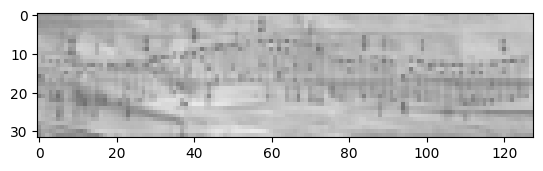

In [ ]:
batch = next(iter(valid_loader))
imgs, target_tokens = batch['img_tensor'], batch['target_ids']
imgs, target_tokens = imgs.to(device), target_tokens.long().to(device)

for img, target in zip(imgs, target_tokens):
    pred = model.decode(img, 192, temperature=0.9, top_k=50)
    print(tokenizer.decode(pred[0].tolist()[1:-1], ignore_special_tokens=True))
    print(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
    plt.imshow(img.cpu().permute(1, 2, 0) * std + mean)
    plt.show();

In [ ]:
model.eval()
refs = []
preds = []
for batch_idx, batch in enumerate(valid_loader):
    imgs, target_tokens = batch['img_tensor'], batch['target_ids']
    imgs, target_tokens = imgs.to(device), target_tokens.long().to(device)
    for img, target in zip(imgs, target_tokens):
        pred = model.decode(img, 192, temperature=0.9, top_k=50)
        refs.append(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
        preds.append(tokenizer.decode(pred[0].tolist()[1:-1]))

In [ ]:
import evaluate

cer_metrics = evaluate.load('cer')
cer_metrics.compute(references=refs, predictions=preds)

0.8710270122034828

In [ ]:
for r, p in zip(refs, preds):
    print('Pred: ', p)
    print('Refe: ', r)
    print(10*'=')

Pred:  Fellor , lity , and the theyphoot a the phint bys per that ot in of
Refe:  Pikachu , but SpongeBob has gained popularity in Japan among
Pred:  យាង COMB AN Playlon ការណ៍ផលប៉ះពាល់ មុន បាន CNNC PLAND TOS TOG BDARTD THE NOCC
Refe:  លោក Brad Adams នាយកការិយាល័យអាស៊ីនៃអង្គការ Human Rights Watch ដែលមានមូលដ្ឋាននៅក្រុងញូវយ៉ក
Pred:  Repan work sown bie propican naparint of the respertodence simations ve have had apper and .
Refe:  to play her in a biopic , and even employed Harlow 's hair stylist to color her hair .
Pred:  បុរស កៃអង្គា ក៏ RPCI ក៏ផ្តល់ឱ្យបាន ព្រឹទ្ធសាសនិង នេះ ត្រូវីដ-១៩ រួចសូម និងកីឡា យកក្កដា និង។ និងស្រូវ
Refe:  បាននិយាយថា គំនិតផ្តួចផ្តើមខ្សែក្រវ៉ាត់ និងផ្លូវ ត្រូវបានទទួលស្វាគមន៍យ៉ាងទូលំទូលាយ
Pred:  កំណត់អង្សរ ដំណឹងធំមួយ ជាពិរំដែរ ហើយ
Refe:  កំណត់នូវ ព្រំដែនអំណាច និងអំពើរបស់
Pred:  ដោយខ្សែភាពផ្សាយរត់ចម្ងាយពីខែមករណីនេះមានវត្ថុ MDL ប្រទេសទាំងកាយពីរដ្ឋាភិបាលបង្ហាញពីនិយាយថា បាន
Refe:  នៅក្នុងហេតុការណ៍គ្រោះថ្នាក់ចរាចរណ៍ទាំង២ករណីនេះ ករណីទី 1 អាចបណ្តាលមកពីរថយន្តបែកកង់ ចំណែកករណីទ